In [1]:
import os
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from tqdm import tqdm

## Load Data and Outputs

In [ ]:
# first big models
weth = []
neth = []
for i in range(1, 9):
    weth.append(f'/outputs/wETH/wETH{i}.h5')
    neth.append(f'/outputs/nETH/nETH{i}.h5')

In [ ]:
import os
os.chdir("/EchoTops")
print(os.getcwd())

In [ ]:
from dataset import DutchDataset

ds = DutchDataset(path='/PCP_cleaned',
                  path_eth='/ETH',
                  metadata='/metadata_fix_with_eth.csv',
                  image_size=(336, 272),
                  bbox=[215,-214,214,-214],
                  split='test',
                  transform_to_mmh=True,)

100%|██████████| 1731/1731 [01:13<00:00, 23.50it/s]


In [4]:
def arr_reconstruct_uint8(
    uint8_array: np.ndarray, missing_val: np.uint8 = 255, undetect_val: np.uint8 = 0, mask_val: float = 64.0, mask2_val: float = 64.0
):
    mask = uint8_array == missing_val
    mask2 = uint8_array == undetect_val
    arr = uint8_array.astype(np.float64)
    arr[mask] = mask_val
    arr[mask2] = mask2_val
    arr = (arr - 64) / 2.0
    return arr

def dbztommh(data):
    data = 10 ** (data * 0.1)
    data = (data / 200) ** (1 / 1.6)
    return data

## Computing Pixel-wise Metrics

In [5]:
def MSE(A, B):
    return np.nanmean((A - B)**2, axis=None)
def MAE(A, B):
    return np.nanmean(np.abs(A - B), axis=None)
def ME(A, B):
    return np.nanmean(np.array(A) - np.array(B), axis=None)

In [ ]:
# calculate MAE and ME and MSE
leadtimes = range(18)

with (h5py.File(weth[0], 'r') as weth1f,
    h5py.File(weth[1], 'r') as weth2f,
    h5py.File(weth[2], 'r') as weth3f,
    h5py.File(weth[3], 'r') as weth4f,
    h5py.File(weth[4], 'r') as weth5f,
    h5py.File(weth[5], 'r') as weth6f,
    h5py.File(weth[6], 'r') as weth7f,
    h5py.File(weth[7], 'r') as weth8f,
    h5py.File(neth[0], 'r') as neth1f,
    h5py.File(neth[1], 'r') as neth2f,
    h5py.File(neth[2], 'r') as neth3f,
    h5py.File(neth[3], 'r') as neth4f,
    h5py.File(neth[4], 'r') as neth5f,
    h5py.File(neth[5], 'r') as neth6f,
    h5py.File(neth[6], 'r') as neth7f,
    h5py.File(neth[7], 'r') as neth8f):
    
    eval_list = [weth1f, weth2f, weth3f, weth4f, weth5f, weth6f, weth7f, weth8f,
             neth1f, neth2f, neth3f, neth4f, neth5f, neth6f, neth7f, neth8f]

    tot_MAE = np.zeros((len(eval_list)+1, len(ds), len(leadtimes)), dtype=np.float64)
    tot_ME = np.zeros((len(eval_list)+1, len(ds), len(leadtimes)), dtype=np.float64)
    tot_MSE = np.zeros((len(eval_list)+1, len(ds), len(leadtimes)), dtype=np.float64)
    
    for idx, sample in enumerate(tqdm(ds, total=len(ds))):
      date = ds.get_common_time(idx).strftime("%Y-%m-%d %H:%M:%S")

      groups = []

      for file in eval_list:
        groups.append(file.require_group(date).require_group('model'))

      groupdata = []
      for j, group in enumerate(groups):
        data = np.zeros([0, 336, 272], dtype=np.uint8)
        for leadtime in leadtimes:
            data = np.append(data, np.array(group.require_group(str(leadtime+1))['data'][()]), axis=0)
        groupdata.append(data)
      
      for leadtime in leadtimes:
        target = sample[1][0][leadtime]

        for j, group in enumerate(groups):
            data = groupdata[j][leadtime]
            output = arr_reconstruct_uint8(data)
            output = dbztommh(output)
            
            tot_MAE[j, idx, leadtime] = MAE(target, output)
            tot_ME[j, idx, leadtime] = ME(output, target)
            tot_MSE[j, idx, leadtime] = MSE(target, output)
        
        output = sample[0][0][-1]
        
        tot_MAE[len(eval_list), idx, leadtime] = MAE(target, output)
        tot_ME[len(eval_list), idx, leadtime] = ME(output, target)
        tot_MSE[len(eval_list), idx, leadtime] = MSE(target, output)


In [ ]:
with h5py.File('test_metrics.h5', 'w') as h5f:
     h5f.create_dataset('MAE', data = tot_MAE)
     h5f.create_dataset('ME', data = tot_ME)
     h5f.create_dataset('MSE', data = tot_MSE)

In [6]:
with h5py.File('test_metrics.h5', 'r') as h5f:
    tot_MAE = h5f['MAE'][()]
    tot_ME = h5f['ME'][()]
    tot_MSE = h5f['MSE'][()]

In [279]:
MAE_dict = {}
ME_dict = {}
MSE_dict = {}

for idx in range(16):
    if idx < 8:
        key = f'weth{idx+1}'
    else:
        key = f'neth{idx-7}'
    MAE_dict[key] = np.nanmean(tot_MAE[idx], axis=0)
    ME_dict[key] = np.nanmean(tot_ME[idx], axis=0)
    MSE_dict[key] = np.nanmean(tot_MSE[idx], axis=0)

idx = idx + 1
    
MAE_dict['Pers'] = np.nanmean(tot_MAE[idx], axis=0)
ME_dict['Pers'] = np.nanmean(tot_ME[idx], axis=0)
MSE_dict['Pers'] = np.nanmean(tot_MSE[idx], axis=0)

leadtimes = range(18)

In [280]:
MAE_dict['weth_mean'] = (MAE_dict['weth1'] + MAE_dict['weth2'] + MAE_dict['weth3'] + MAE_dict['weth4'] + MAE_dict['weth5'] + MAE_dict['weth6'] + MAE_dict['weth7'] + MAE_dict['weth8']) / 8
MAE_dict['neth_mean'] = (MAE_dict['neth1'] + MAE_dict['neth2'] + MAE_dict['neth3'] + MAE_dict['neth4'] + MAE_dict['neth5'] + MAE_dict['neth6'] + MAE_dict['neth7'] + MAE_dict['neth8']) / 8

MSE_dict['weth_mean'] = (MSE_dict['weth1'] + MSE_dict['weth2'] + MSE_dict['weth3'] + MSE_dict['weth4'] + MSE_dict['weth5'] + MSE_dict['weth6'] + MSE_dict['weth7'] + MSE_dict['weth8']) / 8
MSE_dict['neth_mean'] = (MSE_dict['neth1'] + MSE_dict['neth2'] + MSE_dict['neth3'] + MSE_dict['neth4'] + MSE_dict['neth5'] + MSE_dict['neth6'] + MSE_dict['neth7'] + MSE_dict['neth8']) / 8

MAE_dict['weth_std'] = np.std(np.array([MAE_dict['weth1'], MAE_dict['weth2'], MAE_dict['weth3'], MAE_dict['weth4'], MAE_dict['weth5'], MAE_dict['weth6'], MAE_dict['weth7'], MAE_dict['weth8']]), axis=0)
MAE_dict['neth_std'] = np.std(np.array([MAE_dict['neth1'], MAE_dict['neth2'], MAE_dict['neth3'], MAE_dict['neth4'], MAE_dict['neth5'], MAE_dict['neth6'], MAE_dict['neth7'], MAE_dict['neth8']]), axis=0)

MSE_dict['weth_std'] = np.std(np.array([MSE_dict['weth1'], MSE_dict['weth2'], MSE_dict['weth3'], MSE_dict['weth4'], MSE_dict['weth5'], MSE_dict['weth6'], MSE_dict['weth7'], MSE_dict['weth8']]), axis=0)
MSE_dict['neth_std'] = np.std(np.array([MSE_dict['neth1'], MSE_dict['neth2'], MSE_dict['neth3'], MSE_dict['neth4'], MSE_dict['neth5'], MSE_dict['neth6'], MSE_dict['neth7'], MSE_dict['neth8']]), axis=0)

ME_dict['weth_mean'] = (ME_dict['weth1'] + ME_dict['weth2'] + ME_dict['weth3'] + ME_dict['weth4'] + ME_dict['weth5'] + ME_dict['weth6'] + ME_dict['weth7'] + ME_dict['weth8']) / 8
ME_dict['neth_mean'] = (ME_dict['neth1'] + ME_dict['neth2'] + ME_dict['neth3'] + ME_dict['neth4'] + ME_dict['neth5'] + ME_dict['neth6'] + ME_dict['neth7'] + ME_dict['neth8']) / 8

ME_dict['weth_std'] = np.std(np.array([ME_dict['weth1'], ME_dict['weth2'], ME_dict['weth3'], ME_dict['weth4'], ME_dict['weth5'], ME_dict['weth6'], ME_dict['weth7'], ME_dict['weth8']]), axis=0)
ME_dict['neth_std'] = np.std(np.array([ME_dict['neth1'], ME_dict['neth2'], ME_dict['neth3'], ME_dict['neth4'], ME_dict['neth5'], ME_dict['neth6'], ME_dict['neth7'], ME_dict['neth8']]), axis=0)

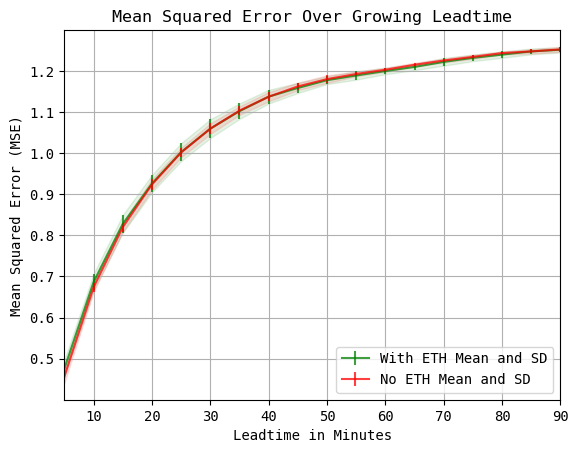

In [ ]:
# MSE plot
%matplotlib inline
x = np.array(leadtimes) * 5 + 5

plt.figure()

plt.errorbar(x, MSE_dict['weth_mean'], yerr=MSE_dict['weth_std'], label='With ETH Mean and SD', color='g', alpha=0.75)
plt.errorbar(x, MSE_dict['neth_mean'], yerr=MSE_dict['neth_std'], label='No ETH Mean and SD', color='r', alpha=0.75)
plt.fill_between(x, MSE_dict['weth_mean'] - MSE_dict['weth_std'], MSE_dict['weth_mean'] + MSE_dict['weth_std'], color='g', alpha=0.1)
plt.fill_between(x, MSE_dict['neth_mean'] - MSE_dict['neth_std'], MSE_dict['neth_mean'] + MSE_dict['neth_std'], color='r', alpha=0.1)
#plt.plot(x, MSE_dict['Pers'], '-', label='Persistence')

#plt.plot(x, MSE_dict['weth5'], '--', label='Best - 3D With ETH Run 5') # best

plt.grid()
  
plt.xlabel("Leadtime in Minutes")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('Mean Squared Error Over Growing Leadtime')
plt.legend(loc="lower right")
#plt.yscale('log')
plt.xlim(5,90)
plt.savefig("mse-8v8.pdf", bbox_inches='tight')

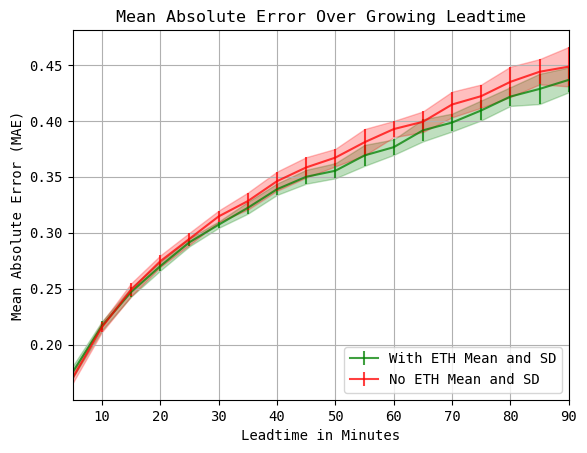

In [ ]:
# MAE plot
%matplotlib inline
x = np.array(leadtimes) * 5 + 5

plt.figure()

#plt.plot(x, MAE_dict['Pers'], '-', label='Persistence')

#plt.plot(x, MAE_dict['weth3'], '--', label='Best - With ETH Run 3') #best

plt.errorbar(x, MAE_dict['weth_mean'], yerr=MAE_dict['weth_std'], label='With ETH Mean and SD', color='g', alpha=0.75)
plt.errorbar(x, MAE_dict['neth_mean'], yerr=MAE_dict['neth_std'], label='No ETH Mean and SD', color='r', alpha=0.75)
plt.fill_between(x, MAE_dict['weth_mean'] - MAE_dict['weth_std'], MAE_dict['weth_mean'] + MAE_dict['weth_std'], color='g', alpha=0.25)
plt.fill_between(x, MAE_dict['neth_mean'] - MAE_dict['neth_std'], MAE_dict['neth_mean'] + MAE_dict['neth_std'], color='r', alpha=0.25)

plt.grid()
  
plt.xlabel("Leadtime in Minutes")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title('Mean Absolute Error Over Growing Leadtime')
plt.legend(loc="lower right")
plt.xlim(5,90)
# plt.yscale('log')
plt.savefig("mae-8v8.pdf", bbox_inches='tight')
#plt.show()

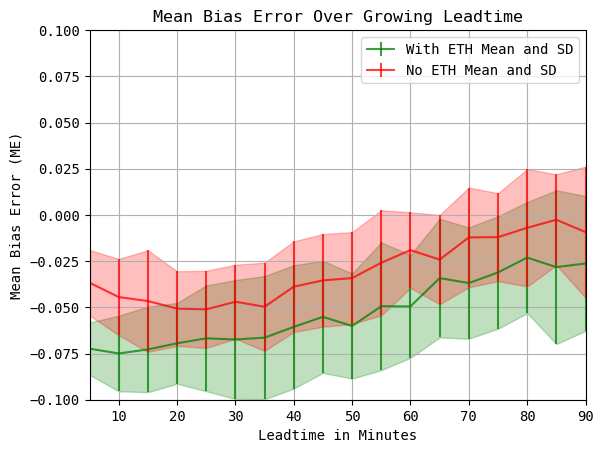

In [ ]:
# ME plot
%matplotlib inline
x = np.array(leadtimes) * 5 + 5

plt.figure()

#plt.plot(x, ME_dict['neth6'], '--', label='Best - No ETH Run 6')

plt.errorbar(x, ME_dict['weth_mean'], yerr=ME_dict['weth_std'], label='With ETH Mean and SD', color='g', alpha=0.75)
plt.errorbar(x, ME_dict['neth_mean'], yerr=ME_dict['neth_std'], label='No ETH Mean and SD', color='r', alpha=0.75)
plt.fill_between(x, ME_dict['weth_mean'] - ME_dict['weth_std'], ME_dict['weth_mean'] + ME_dict['weth_std'], color='g', alpha=0.25)
plt.fill_between(x, ME_dict['neth_mean'] - ME_dict['neth_std'], ME_dict['neth_mean'] + ME_dict['neth_std'], color='r', alpha=0.25)

#plt.plot(x, ME_dict['Pers'], '-', label='Persistence')

ax = plt.gca()

plt.grid()
  
plt.xlabel("Leadtime in Minutes")
plt.ylabel("Mean Bias Error (ME)")
plt.title('Mean Bias Error Over Growing Leadtime')
plt.legend(loc="upper right")
plt.ylim(-0.1,0.1)
plt.xlim(5,90)
plt.savefig("me-8v8.pdf", bbox_inches='tight')
#plt.show()

## Computing Thresholded Metrics

In [ ]:
# calculate elements of confusion matrix
leadtimes = range(18)
thresholds = [1, 5, 10]

def get_conf_mat(pred, target, threshold):
    pred_mask = pred.flatten() > threshold
    target_mask = target.flatten() > threshold
    tn, fp, fn, tp = np.bincount(target_mask*2 + pred_mask, minlength=4)
    return tn, fp, fn, tp

def get_disc_metrics(tn, fp, fn, tp):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    a_r = ((tp + fp) * (tp + fn))/(tp + fp + tn + fn)
    ets = (tp - a_r)/(tp + fp + fn - a_r)
    far = fp / (tp + fp)
    return precision, recall, accuracy, ets, far

with (h5py.File(weth[0], 'r') as weth1f,
    h5py.File(weth[1], 'r') as weth2f,
    h5py.File(weth[2], 'r') as weth3f,
    h5py.File(weth[3], 'r') as weth4f,
    h5py.File(weth[4], 'r') as weth5f,
    h5py.File(weth[5], 'r') as weth6f,
    h5py.File(weth[6], 'r') as weth7f,
    h5py.File(weth[7], 'r') as weth8f,
    h5py.File(neth[0], 'r') as neth1f,
    h5py.File(neth[1], 'r') as neth2f,
    h5py.File(neth[2], 'r') as neth3f,
    h5py.File(neth[3], 'r') as neth4f,
    h5py.File(neth[4], 'r') as neth5f,
    h5py.File(neth[5], 'r') as neth6f,
    h5py.File(neth[6], 'r') as neth7f,
    h5py.File(neth[7], 'r') as neth8f):
    
    eval_list = [weth1f, weth2f, weth3f, weth4f, weth5f, weth6f, weth7f, weth8f,
             neth1f, neth2f, neth3f, neth4f, neth5f, neth6f, neth7f, neth8f]

    tot_tn = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)
    tot_fp = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)
    tot_fn = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)
    tot_tp = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)

    for i, sample in enumerate(tqdm(ds, total=len(ds))):
      date = ds.get_common_time(i).strftime("%Y-%m-%d %H:%M:%S")

      groups = []

      for file in eval_list:
        groups.append(file.require_group(date).require_group('model'))

      groupdata = []
      for j, group in enumerate(groups):
        data = np.zeros([0, 336, 272], dtype=np.uint8)
        for leadtime in leadtimes:
            data = np.append(data, np.array(group.require_group(str(leadtime+1))['data'][()]), axis=0)
        groupdata.append(data)
      
      for leadtime in leadtimes:
        target = sample[1][0][leadtime]

        for j, group in enumerate(groups):
            data = groupdata[j][leadtime]
            output = arr_reconstruct_uint8(data)
            output = dbztommh(output)
        
            for k, threshold in enumerate(thresholds):
              tn, fp, fn, tp = get_conf_mat(output, target, threshold)
              tot_tn[j, k, leadtime] += tn
              tot_fp[j, k, leadtime] += fp
              tot_fn[j, k, leadtime] += fn
              tot_tp[j, k, leadtime] += tp
            
        output = sample[0][0][-1]  # persistence
      
        for k, threshold in enumerate(thresholds):
            tn, fp, fn, tp = get_conf_mat(output, target, threshold)
            tot_tn[len(eval_list), k, leadtime] += tn
            tot_fp[len(eval_list), k, leadtime] += fp
            tot_fn[len(eval_list), k, leadtime] += fn
            tot_tp[len(eval_list), k, leadtime] += tp

In [ ]:
def get_disc_metrics(tn, fp, fn, tp):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    a_r = ((tp + fp) * (tp + fn))/(tp + fp + tn + fn)
    ets = (tp - a_r)/(tp + fp + fn - a_r)
    far = fp / (tp + fp)
    csi = tp / (tp + fn + fp)
    return precision, recall, accuracy, ets, far, csi  

precision = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)
recall = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)
accuracy = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)
ets = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)
far = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)
csi = np.zeros((len(eval_list)+1, len(thresholds), len(leadtimes)), dtype=np.float64)

for i in range(len(eval_list)+1):
    for j in range(len(thresholds)):
        for k in range(len(leadtimes)):
            precision[i, j, k], recall[i, j, k], accuracy[i, j, k], ets[i, j, k], far[i, j, k], csi[i, j, k] = get_disc_metrics(tot_tn[i, j, k], tot_fp[i, j, k], tot_fn[i, j, k], tot_tp[i, j, k])

In [ ]:
with h5py.File('test_metrics.h5', 'a') as h5f:
     h5f.create_dataset('precision', data = precision)
     h5f.create_dataset('recall', data = recall)
     h5f.create_dataset('accuracy', data = accuracy)
     h5f.create_dataset('ets', data = ets)
     h5f.create_dataset('far', data = far)
     h5f.create_dataset('csi', data = csi)

In [67]:
with h5py.File('test_metrics.h5', 'a') as h5f:
     precision = h5f['precision'][()]
     recall = h5f['recall'][()]
     accuracy = h5f['accuracy'][()]
     ets = h5f['ets'][()]
     far = h5f['far'][()]
     csi = h5f['csi'][()]

In [295]:
leadtimes = np.arange(18) + 1
thresholds = [0.1, 1, 2.5, 5, 10]

precision_dict = {}
recall_dict = {}
accuracy_dict = {}
ets_dict = {}
far_dict = {}
csi_dict = {}

threshold_idx = 1

for i in range(17):
    if i < 8:
        key = f'weth{i+1}'
    elif i < 16:
        key = f'neth{i-8+1}'
    else:
        key = 'Pers'

    precision_dict[key] = precision[i][threshold_idx]
    recall_dict[key] = recall[i][threshold_idx]
    accuracy_dict[key] = accuracy[i][threshold_idx]
    ets_dict[key] = ets[i][threshold_idx]
    far_dict[key] = far[i][threshold_idx]
    csi_dict[key] = csi[i][threshold_idx]

precision_dict['weth_mean'] = (precision_dict['weth1'] + precision_dict['weth2'] + precision_dict['weth3'] + precision_dict['weth4'] + precision_dict['weth5'] + precision_dict['weth6'] + precision_dict['weth7'] + precision_dict['weth8']) / 8
precision_dict['neth_mean'] = (precision_dict['neth1'] + precision_dict['neth2'] + precision_dict['neth3'] + precision_dict['neth4'] + precision_dict['neth5'] + precision_dict['neth6'] + precision_dict['neth7'] + precision_dict['neth8']) / 8
precision_dict['weth_std'] = np.std(np.array([precision_dict['weth1'], precision_dict['weth2'], precision_dict['weth3'], precision_dict['weth4'], precision_dict['weth5'], precision_dict['weth6'], precision_dict['weth7'], precision_dict['weth8']]), axis=0)
precision_dict['neth_std'] = np.std(np.array([precision_dict['neth1'], precision_dict['neth2'], precision_dict['neth3'], precision_dict['neth4'], precision_dict['neth5'], precision_dict['neth6'], precision_dict['neth7'], precision_dict['neth8']]), axis=0)

recall_dict['weth_mean'] = (recall_dict['weth1'] + recall_dict['weth2'] + recall_dict['weth3'] + recall_dict['weth4'] + recall_dict['weth5'] + recall_dict['weth6'] + recall_dict['weth7'] + recall_dict['weth8']) / 8
recall_dict['neth_mean'] = (recall_dict['neth1'] + recall_dict['neth2'] + recall_dict['neth3'] + recall_dict['neth4'] + recall_dict['neth5'] + recall_dict['neth6'] + recall_dict['neth7'] + recall_dict['neth8']) / 8
recall_dict['weth_std'] = np.std(np.array([recall_dict['weth1'], recall_dict['weth2'], recall_dict['weth3'], recall_dict['weth4'], recall_dict['weth5'], recall_dict['weth6'], recall_dict['weth7'], recall_dict['weth8']]), axis=0)
recall_dict['neth_std'] = np.std(np.array([recall_dict['neth1'], recall_dict['neth2'], recall_dict['neth3'], recall_dict['neth4'], recall_dict['neth5'], recall_dict['neth6'], recall_dict['neth7'], recall_dict['neth8']]), axis=0)

ets_dict['weth_mean'] = (ets_dict['weth1'] + ets_dict['weth2'] + ets_dict['weth3'] + ets_dict['weth4'] + ets_dict['weth5'] + ets_dict['weth6'] + ets_dict['weth7'] + ets_dict['weth8']) / 8
ets_dict['neth_mean'] = (ets_dict['neth1'] + ets_dict['neth2'] + ets_dict['neth3'] + ets_dict['neth4'] + ets_dict['neth5'] + ets_dict['neth6'] + ets_dict['neth7'] + ets_dict['neth8']) / 8
ets_dict['weth_std'] = np.std(np.array([ets_dict['weth1'], ets_dict['weth2'], ets_dict['weth3'], ets_dict['weth4'], ets_dict['weth5'], ets_dict['weth6'], ets_dict['weth7'], ets_dict['weth8']]), axis=0)
ets_dict['neth_std'] = np.std(np.array([ets_dict['neth1'], ets_dict['neth2'], ets_dict['neth3'], ets_dict['neth4'], ets_dict['neth5'], ets_dict['neth6'], ets_dict['neth7'], ets_dict['neth8']]), axis=0)

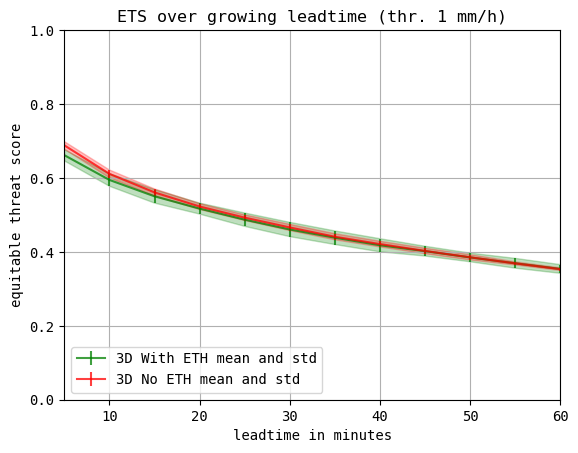

In [296]:
# ME plot
%matplotlib inline
x = np.array(leadtimes) * 5

plt.figure()

#for i in range(0,4):
#    plt.plot(x, ets_dict['weth'+str(i+1)], ':', label='3D With ETH '+str(i+1), color='g')
#    plt.plot(x, ets_dict['neth'+str(i+1)], ':', label='3D No ETH '+str(i+1), color='r')

plt.errorbar(x, ets_dict['weth_mean'], yerr=ets_dict['weth_std'], label='3D With ETH mean and std', color='g', alpha=0.75)
plt.errorbar(x, ets_dict['neth_mean'], yerr=ets_dict['neth_std'], label='3D No ETH mean and std', color='r', alpha=0.75)
plt.fill_between(x, ets_dict['weth_mean'] - ets_dict['weth_std'], ets_dict['weth_mean'] + ets_dict['weth_std'], color='g', alpha=0.25)
plt.fill_between(x, ets_dict['neth_mean'] - ets_dict['neth_std'], ets_dict['neth_mean'] + ets_dict['neth_std'], color='r', alpha=0.25)

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("equitable threat score")
plt.title(f'ETS over growing leadtime (thr. {thresholds[threshold_idx]} mm/h)')
plt.legend(loc="lower left")
plt.xlim(5,60)
plt.ylim(0,1)
plt.savefig(f"ets-8v8-{thresholds[threshold_idx]}.pdf", bbox_inches='tight')

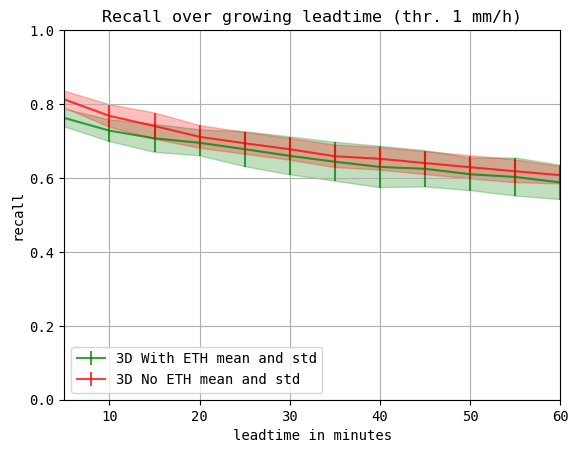

In [297]:
# ME plot
%matplotlib inline
x = np.array(leadtimes) * 5
plt.figure()

#for i in range(0,4):
#    plt.plot(x, recall_dict['weth'+str(i+1)], ':', label='3D With ETH '+str(i+1), color='g')
#    plt.plot(x, recall_dict['neth'+str(i+1)], ':', label='3D No ETH '+str(i+1), color='r')

plt.errorbar(x, recall_dict['weth_mean'], yerr=recall_dict['weth_std'], label='3D With ETH mean and std', color='g', alpha=0.75)
plt.errorbar(x, recall_dict['neth_mean'], yerr=recall_dict['neth_std'], label='3D No ETH mean and std', color='r', alpha=0.75)
plt.fill_between(x, recall_dict['weth_mean'] - recall_dict['weth_std'], recall_dict['weth_mean'] + recall_dict['weth_std'], color='g', alpha=0.25)
plt.fill_between(x, recall_dict['neth_mean'] - recall_dict['neth_std'], recall_dict['neth_mean'] + recall_dict['neth_std'], color='r', alpha=0.25)

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("recall")
plt.title(f'Recall over growing leadtime (thr. {thresholds[threshold_idx]} mm/h)')
plt.legend(loc="lower left")
plt.xlim(5,60)
plt.ylim(0,1)
plt.savefig(f"recall-8v8-{thresholds[threshold_idx]}.pdf", bbox_inches='tight')

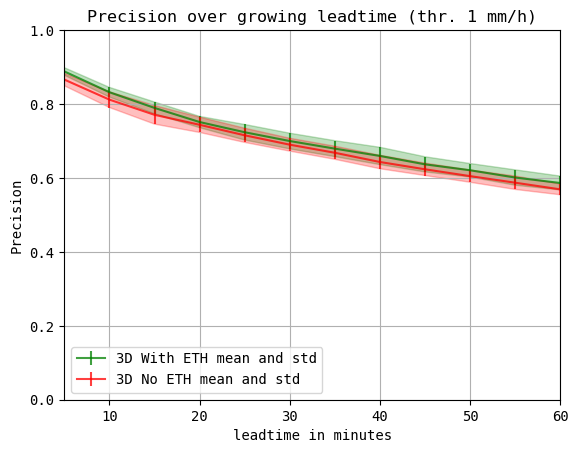

In [298]:
# ME plot
%matplotlib inline
x = np.array(leadtimes) * 5

plt.figure()

#for i in range(0,4):
#    plt.plot(x, precision_dict['weth'+str(i+1)], ':', label='3D With ETH '+str(i+1), color='g')
#    plt.plot(x, precision_dict['neth'+str(i+1)], ':', label='3D No ETH '+str(i+1), color='r')
#plt.plot(x, csi_dict['Pers'], '-', label='Persistence')

plt.errorbar(x, precision_dict['weth_mean'], yerr=precision_dict['weth_std'], label='3D With ETH mean and std', color='g', alpha=0.75)
plt.errorbar(x, precision_dict['neth_mean'], yerr=precision_dict['neth_std'], label='3D No ETH mean and std', color='r', alpha=0.75)
plt.fill_between(x, precision_dict['weth_mean'] - precision_dict['weth_std'], precision_dict['weth_mean'] + precision_dict['weth_std'], color='g', alpha=0.25)
plt.fill_between(x, precision_dict['neth_mean'] - precision_dict['neth_std'], precision_dict['neth_mean'] + precision_dict['neth_std'], color='r', alpha=0.25)

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("Precision")
plt.title(f'Precision over growing leadtime (thr. {thresholds[threshold_idx]} mm/h)')
plt.legend(loc="lower left")
plt.xlim(5,60)
plt.ylim(0,1)
plt.savefig(f"precision-8v8-{thresholds[threshold_idx]}.pdf", bbox_inches='tight')

## Test Data visualization

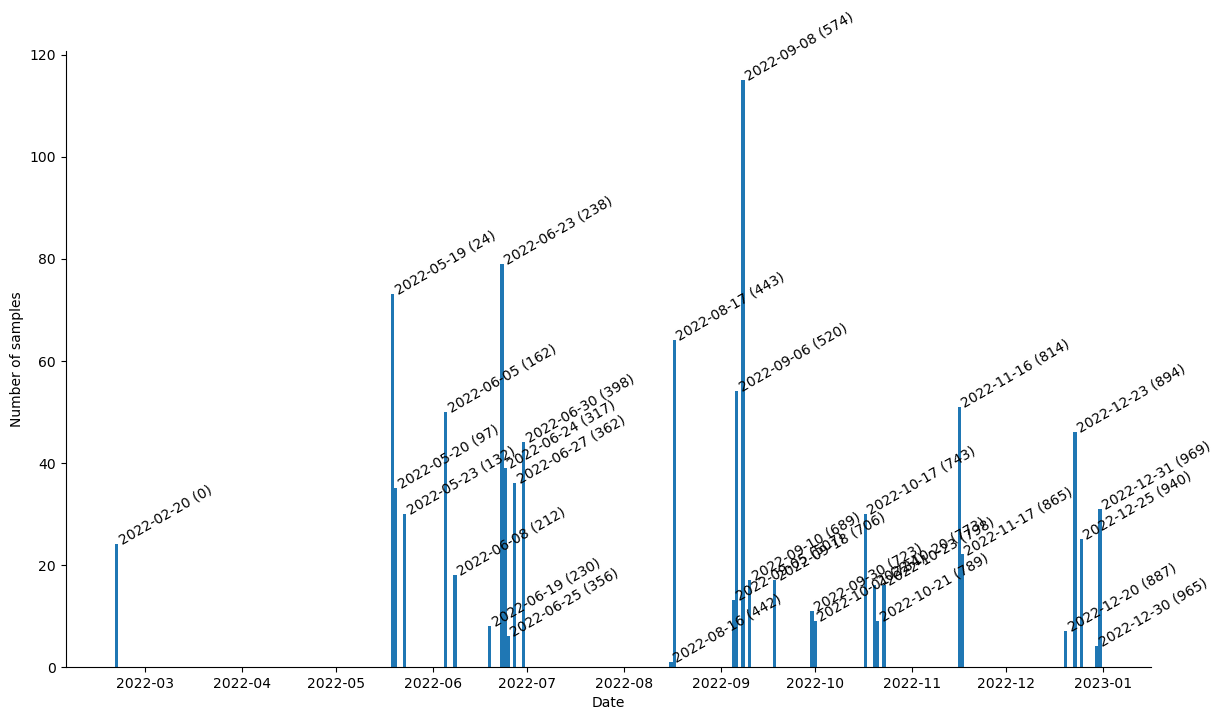

In [11]:
import pandas as pd

datedatelist = ds.datelist.map(lambda x: x.date())
dates = datedatelist.value_counts().sort_index()#.plot(kind='bar', figsize=(12, 6), title='Number of samples per day')
dates.index = pd.to_datetime(dates.index)
#dates.plot(kind='bar', figsize=(12, 6), title='Number of samples per day')

fig, ax = plt.subplots(1, figsize=(14, 8))
ax.bar(dates.index, dates.values, width=1)
ax.xaxis_date()

ax.set_xlabel('Date')
ax.set_ylabel('Number of samples')

ax.spines[['right', 'top']].set_visible(False)

for i in range(len(dates)):
    ax.text(dates.index[i], dates.iloc[i], str(dates.index[i].date()) + ' (' + str(np.searchsorted(datedatelist, dates.index[i].date())) + ')', color='black', fontsize=10, ha='left', rotation=30)

plt.show()

## Events visualization

In [82]:
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
import numpy as np

def arr_reconstruct_uint8(
    uint8_array: np.ndarray, missing_val: np.uint8 = 255, undetect_val: np.uint8 = 0, mask_val: float = 64.0, mask2_val: float = 64.0
):
    mask = uint8_array == missing_val
    mask2 = uint8_array == undetect_val
    arr = uint8_array.astype(np.float64)
    arr[mask] = mask_val
    arr[mask2] = mask2_val
    arr = (arr - 64) / 2.0
    return arr

plt.rcParams["font.family"] = "monospace"

sample_idx = 501 # 51
sample_key = ds.get_common_time(sample_idx).strftime("%Y-%m-%d %H:%M:%S")
print(sample_key)

lead = 18

x, y, idx = ds[sample_idx]
x[0] = ds.from_transformed(x[0])
x = np.array(x)
arr = np.zeros((lead, 336, 272))
y_arr = np.zeros((lead, 336, 272))

f = h5py.File(weth[4], 'r')
for i in range(0, lead):
    arr[i] = np.array(f[sample_key]['model'][f'{i+1}']['data'])
arr_WETH3D = arr_reconstruct_uint8(arr)
f.close()

f = h5py.File(neth[5], 'r')
for i in range(0, lead):
    arr[i] = np.array(f[sample_key]['model'][f'{i+1}']['data'])
arr_NETH3D = arr_reconstruct_uint8(arr)
f.close()

for i in range(0, lead):
    y_arr[i] = np.array(ds.from_transformed(y[0][i]))

def dbztommh(data, zero_lower_bound=0):
    data = 10 ** (data * 0.1)
    data = (data / 200) ** (1 / 1.6)
    data[data < zero_lower_bound] = 0
    return data

2022-08-17 15:00:00


In [50]:
from pysteps.visualization import plot_precip_field

def plottoax(map, ax, title):
    ax.clear()
    plot_precip_field(dbztommh(map, zero_lower_bound=0.25), colorbar=False, units='mm/h', ax=ax)
    # axes[0].axis('off')
    ax.xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 34)
    ax.yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True, alpha=0.5)

    # x1, x2, y1, y2 = 3*42, 4*42, 4.5*42, 5.5*42  # subregion of the original image
    # axins = ax.inset_axes(
    #     [0.025, 0.025, 0.375, 0.375],
    #     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    # plot_precip_field(dbztommh(map), colorbar=False, units='mm/h', ax=axins)
    # ax.indicate_inset_zoom(axins, edgecolor="black")
    
    ax.set_title(title)

def MSE(A, B):
    return np.nanmean((A - B)**2, axis=None)
def MAE(A, B):
    return np.nanmean(np.abs(A - B), axis=None)
def ME(A, B):
    return np.nanmean(np.array(A) - np.array(B), axis=None)

/home/ppavlik/miniconda3/envs/nowcasting/lib/python3.12/site-packages/pysteps/visualization/precipfields.py:219: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(
/home/ppavlik/miniconda3/envs/nowcasting/lib/python3.12/site-packages/pysteps/visualization/precipfields.py:219: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(


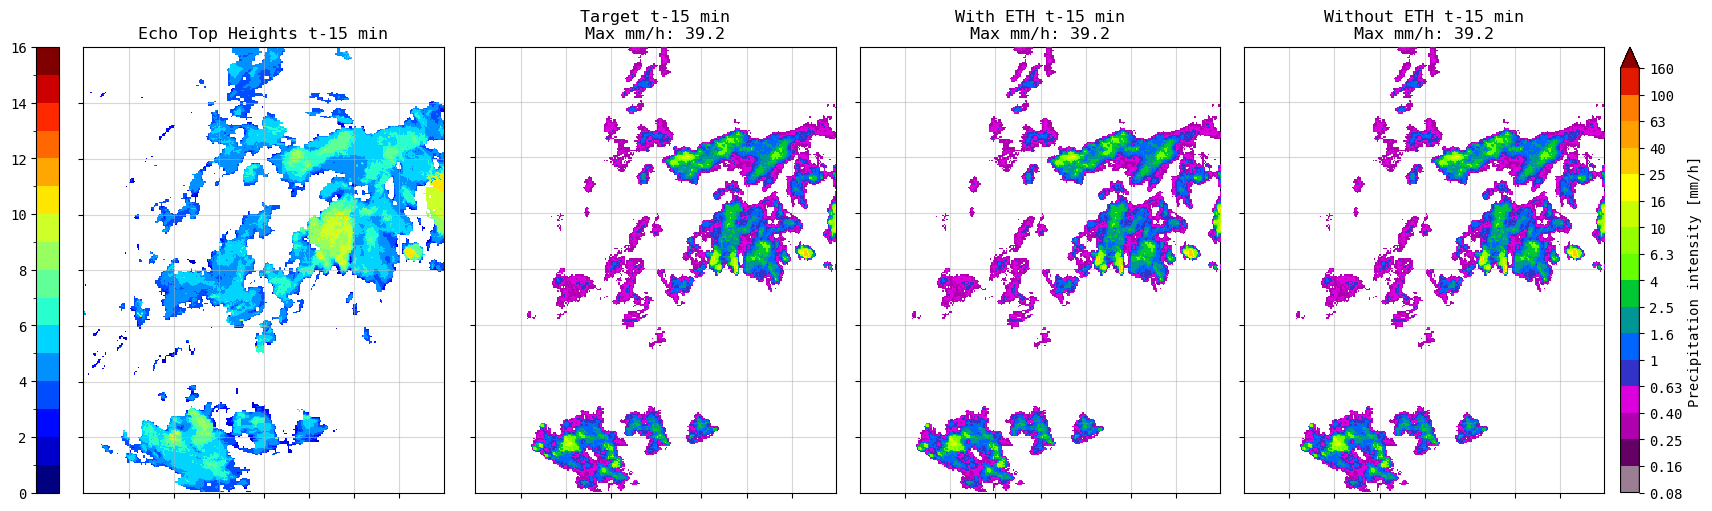

In [83]:
import matplotlib as mpl

fig, axes = plt.subplots(1, 5, figsize=(17,5), width_ratios=(1, 1, 1, 1, 0.05), layout='constrained')

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Stepped Turbo', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 16, 17)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot_precip_field(np.zeros((1,1)), colorbar=True, units='mm/h', ax=axes[0], cax=axes[4])
im = axes[0].imshow(x[1][1], cmap=cmap, norm=norm)
fig.colorbar(im, ax=axes[0], location='left')

def update(i):
    if i < len(x[0]):
        plottoax(x[0][i], axes[1], f'Target t-{(len(x[0])-i-1)*5} min')
        axes[1].set_title(f'Target t-{(len(x[0])-i-1)*5} min\nMax mm/h: {np.max(dbztommh(x[0][i])):.1f}')
        
        eth = x[1][i].copy()
        eth[eth < 1] = np.nan
        axes[0].clear()
        axes[0].imshow(eth, cmap=cmap, norm=norm)
        axes[0].set_xticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 34)
        axes[0].set_yticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
        axes[0].set_title(f'Echo Top Heights t-{(len(x[0])-i-1)*5} min')
        axes[0].xaxis.set_ticklabels([])
        axes[0].yaxis.set_ticklabels([])
        axes[0].grid(True, alpha=0.5)

        plottoax(x[0][i], axes[2], f'With ETH t-{(len(x[0])-i-1)*5} min')
        axes[2].set_title(f'With ETH t-{(len(x[0])-i-1)*5} min\nMax mm/h: {np.max(dbztommh(x[0][i])):.1f}')
        plottoax(x[0][i], axes[3], f'Without ETH t-{(len(x[0])-i-1)*5} min')
        axes[3].set_title(f'Without ETH t-{(len(x[0])-i-1)*5} min\nMax mm/h: {np.max(dbztommh(x[0][i])):.1f}')
    else:
        plottoax(y_arr[i-len(x[0])], axes[1], f'Target t+{(i+1-len(x[0]))*5} min')
        axes[1].set_title(f'Target t+{(i+1-len(x[0]))*5} min\nMax mm/h: {np.max(dbztommh(y_arr[i-len(x[0])])):.1f}')
    
        eth = y[1][i-len(x[0])].clone()
        eth[eth < 1] = np.nan
        axes[0].clear()
        axes[0].imshow(eth, cmap=cmap, norm=norm)
        axes[0].set_xticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 34)
        axes[0].set_yticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
        axes[0].set_title(f'Echo Top Heights t+{(i+1-len(x[0]))*5} min')
        axes[0].xaxis.set_ticklabels([])
        axes[0].yaxis.set_ticklabels([])
        axes[0].grid(True, alpha=0.5)

        plottoax((arr_WETH3D[i-len(x[0])]), axes[2], f'With ETH t+{(i+1-len(x[0]))*5} min')
        axes[2].set_title(f'With ETH t+{(i+1-len(x[0]))*5} min\nMax mm/h: {np.max(dbztommh(arr_WETH3D[i-len(x[0])])):.1f}')
        plottoax(arr_NETH3D[i-len(x[0])], axes[3], f'Without ETH t+{(i+1-len(x[0]))*5} min')
        axes[3].set_title(f'Without ETH t+{(i+1-len(x[0]))*5} min\nMax mm/h: {np.max(dbztommh(arr_NETH3D[i-len(x[0])])):.1f}')

ani = animate.FuncAnimation(fig=fig, func=update, frames=lead+len(x[0]))
htmlstring = HTML(ani.to_jshtml())

filename = ''.join(c for c in sample_key if c.isdigit() or c == '-' or c == ' ')
with open(f"{filename}-4v5.html", "w") as file:
    file.write(htmlstring.data)

/home/ppavlik/miniconda3/envs/nowcasting/lib/python3.12/site-packages/pysteps/visualization/precipfields.py:219: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(
/home/ppavlik/miniconda3/envs/nowcasting/lib/python3.12/site-packages/pysteps/visualization/precipfields.py:219: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(


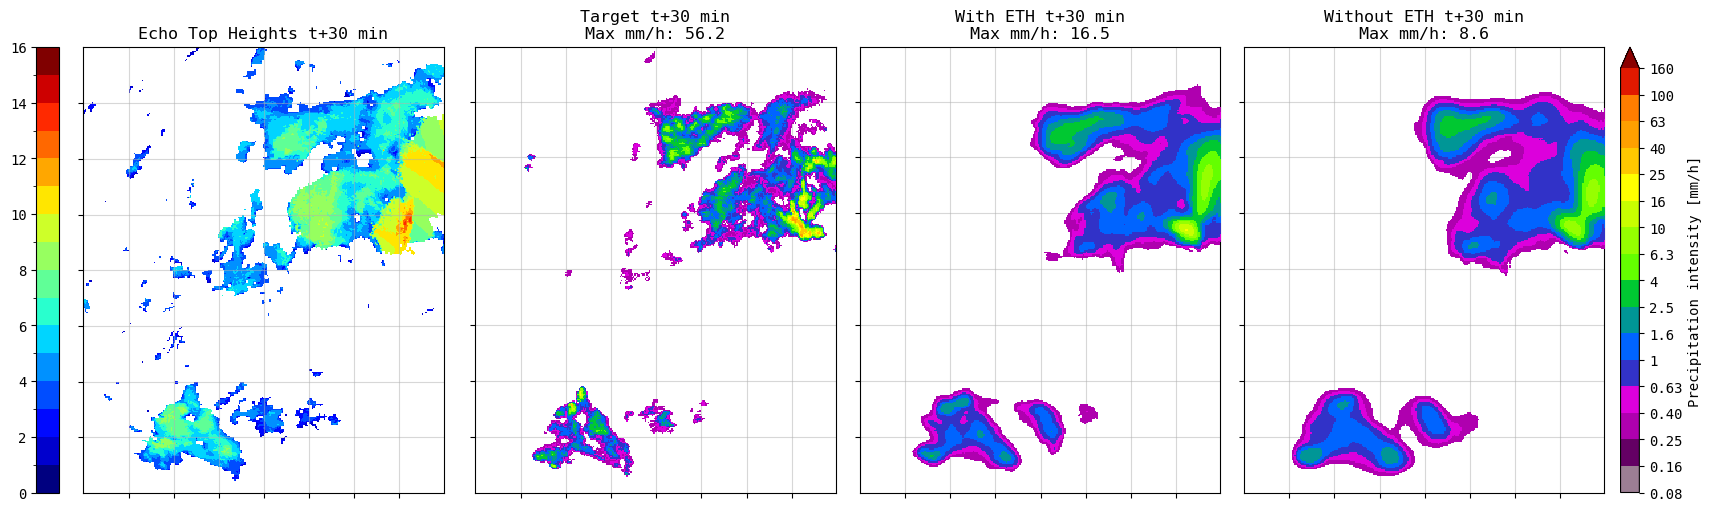

In [86]:
fig, axes = plt.subplots(1, 5, figsize=(17,5), width_ratios=(1, 1, 1, 1, 0.05), layout='constrained')

plot_precip_field(np.zeros((1,1)), colorbar=True, units='mm/h', ax=axes[0], cax=axes[4])
im = axes[0].imshow(x[1][1], cmap=cmap, norm=norm)
fig.colorbar(im, ax=axes[0], location='left')

l = 5
update(l+4)

filename = ''.join(c for c in sample_key if c.isdigit() or c == '-' or c == ' ')
plt.savefig(f"Plot {filename}-4v5-{(l+1)*5}.pdf", bbox_inches='tight')

## Single Sample Visualization

/home/ppavlik/miniconda3/envs/nowcasting/lib/python3.12/site-packages/pysteps/visualization/precipfields.py:219: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(
/home/ppavlik/miniconda3/envs/nowcasting/lib/python3.12/site-packages/pysteps/visualization/precipfields.py:219: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(


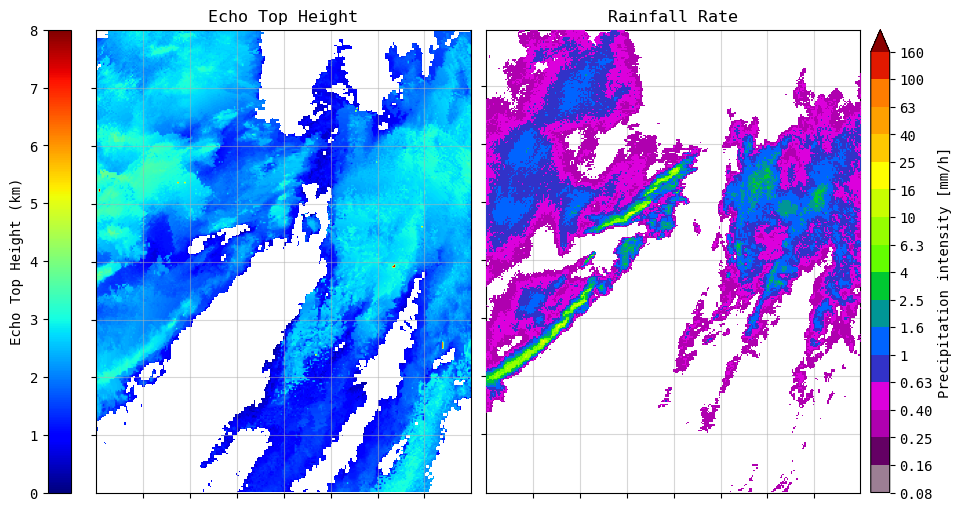

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Create static figure with only two subplots and a colorbar axis
fig, axes = plt.subplots(1, 3, figsize=(9.5, 5), width_ratios=(1, 1, 0.05), layout='constrained')
plot_precip_field(np.zeros((1,1)), colorbar=True, units='mm/h', ax=axes[0], cax=axes[2])

eth = x[1][-1].copy()
eth[eth == 0] = np.nan

# Display ETH field at time index 0
axes[0].set_title(f'Echo Top Height')
axes[0].xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 34)
axes[0].yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
axes[0].xaxis.set_ticklabels([])
axes[0].yaxis.set_ticklabels([])
axes[0].grid(True, alpha=0.5)
im = axes[0].imshow(eth, cmap='jet', vmin=0, vmax=8)

fig.colorbar(im, ax=axes[0], location='left', label='Echo Top Height (km)')

# Display corresponding target field using your custom plot function
plottoax(x[0][-1], axes[1], f'Rainfall Rate')
#axes[1].set_xticks([])
#axes[1].set_yticks([])

plt.savefig(f"EchoTop.pdf", bbox_inches='tight')

# Sample-wise Metrics Visualization

In [7]:
def calculate_linear_slope(input_arr):
    x = torch.arange(len(input_arr)).float()
    y = input_arr
    n = len(x)
    
    x_mean = torch.mean(x) 
    y_mean = torch.mean(y)
    
    Sxy = torch.sum(x*y)- n*x_mean*y_mean 
    Sxx = torch.sum(x*x)-n*x_mean*x_mean 
    
    return Sxy/Sxx

pcp_mean = []
pcp_top = []
pcp_slope = []

eth_mean = []
eth_top = []
eth_slope = []

dates = []
times= []

for sample in tqdm(ds):
    pcp = torch.concat((sample[0], sample[1]), axis=1)[0]
    pcp = pcp.flatten(1,2)
    pcp_mean.append(torch.mean(pcp, dim=1))
    pcp_top.append(torch.quantile(pcp, 0.999999, dim=1))
    pcp_slope.append(calculate_linear_slope(torch.mean(pcp, dim=1)))

    eth = torch.concat((sample[0], sample[1]), axis=1)[1]
    eth = eth.flatten(1,2)
    eth_mean.append(torch.mean(eth, dim=1))
    eth_top.append(torch.quantile(eth, 0.999999, dim=1))
    eth_slope.append(calculate_linear_slope(torch.mean(eth, dim=1)))

    dates.append(ds.get_common_time(sample[2]).date())
    times.append(ds.get_common_time(sample[2]).time())

100%|██████████| 1000/1000 [04:32<00:00,  3.66it/s]


In [11]:
pcp_mean_np = np.array(pcp_mean)
eth_mean_np = np.array(eth_mean)

pcp_top_np = np.array(pcp_top)
eth_top_np = np.array(eth_top)

pcp_slope_np = np.array(pcp_slope)
eth_slope_np = np.array(eth_slope)

In [55]:
l = 6

mean_weth_mae = np.mean([tot_MAE[i, :, :l].mean(axis=1) for i in range(8)], axis=0)
mean_neth_mae = np.mean([tot_MAE[i + 8, :, :l].mean(axis=1) for i in range(8)], axis=0)

mean_weth_mse = np.mean([tot_MSE[i, :, :l].mean(axis=1) for i in range(8)], axis=0)
mean_neth_mse = np.mean([tot_MSE[i + 8, :, :l].mean(axis=1) for i in range(8)], axis=0)

mean_weth_me = np.mean([tot_ME[i, :, :l].mean(axis=1) for i in range(8)], axis=0)
mean_neth_me = np.mean([tot_ME[i + 8, :, :l].mean(axis=1) for i in range(8)], axis=0)

mae_diff = mean_weth_mae - mean_neth_mae
mse_diff = mean_weth_mse - mean_neth_mse
me_diff = mean_weth_me - mean_neth_me

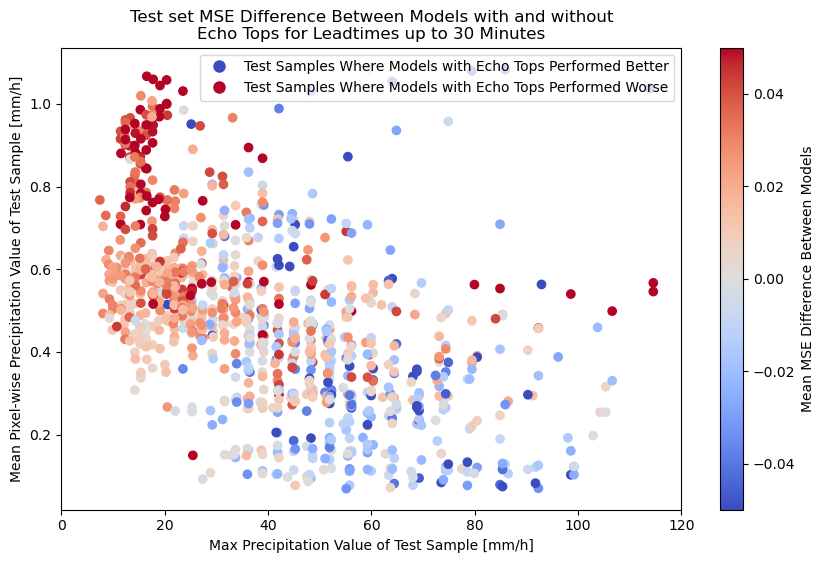

In [69]:
import matplotlib as mpl
from matplotlib.lines import Line2D

coolwarm = mpl.colormaps['coolwarm']

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(pcp_top_np[:,l+4], pcp_mean_np[:,l+4], c=mse_diff, vmin=-0.05, vmax=0.05, cmap='coolwarm', alpha=1)

plt.colorbar(label='Mean MSE Difference Between Models')

plt.xlim(0, 120)
#plt.ylim(8, 15)

plt.xlabel('Max Precipitation Value of Test Sample [mm/h]')
plt.ylabel('Mean Pixel-wise Precipitation Value of Test Sample [mm/h]')

plt.title('Test set MSE Difference Between Models with and without\nEcho Tops for Leadtimes up to 30 Minutes')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Test Samples Where Models with Echo Tops Performed Better',
                          markerfacecolor=coolwarm(0.0), markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Test Samples Where Models with Echo Tops Performed Worse',
                          markerfacecolor=coolwarm(1.0), markersize=10)]

plt.legend(handles=legend_elements)

#plt.show()

plt.savefig(f"mse-8v8-test-set-2.pdf", bbox_inches='tight')

# zaporne - modre su sample, kde bol vyssi error bez ETH
# kladne - cervene su sample, kde bol vyssi error s ETH

# Compute Fractions Skill Score

In [23]:
from pysteps.verification import fss

def fss_wrapper(forecast, observation, thr=(1, 5, 10), scale=(1, 4, 16)):
    
    results = np.ones((len(thr), len(scale)))

    for i, t in enumerate(thr):
        for j, s in enumerate(scale):
            results[i, j] =  fss(forecast, observation, thr=t, scale=s)

    return results

def fss_visualize(res, thr=(1, 2.5, 5, 10), scale=(1, 4, 16), ax=None, subtitle=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.33, 3.33))
    im = ax.imshow(res, origin="lower", cmap="viridis", vmin=0, vmax=1)

    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            text = ax.text(j, i, f"{res[i, j]:.2f}", ha="center", va="center", color="black")

    ax.set_yticks(range(len(thr)), labels=thr)
    ax.set_xticks(range(len(scale)), labels=scale)

    ax.set_xlabel("Scale [km]")
    ax.set_ylabel("Precipitation Threshold [mm/h]")
    ax.set_title("Fractions Skill Score" + (f"\n{subtitle}" if subtitle is not None else ""))

Pysteps configuration file found at: /home/ppavlik/miniconda3/envs/nowcasting/lib/python3.12/site-packages/pysteps/pystepsrc



In [58]:
# calculate MAE and ME and MSE
leadtimes = range(18)

fss_thr = (1, 2.5, 5, 10)
fss_scale = (1, 4, 16)

with (h5py.File(weth1, 'r') as weth1f,
      h5py.File(weth2, 'r') as weth2f,
      h5py.File(weth3, 'r') as weth3f,
      h5py.File(weth4, 'r') as weth4f,
      h5py.File(neth1, 'r') as neth1f,
      h5py.File(neth2, 'r') as neth2f,
      h5py.File(neth3, 'r') as neth3f,
      h5py.File(neth4, 'r') as neth4f):
    
    eval_list = [weth1f, weth2f, weth3f, weth4f, neth1f, neth2f, neth3f, neth4f]

    tot_FSS = np.zeros((len(eval_list)+1, len(ds), len(leadtimes), len(fss_thr), len(fss_scale)), dtype=np.float64)
    
    for i, sample in enumerate(tqdm(ds, total=len(ds))):
        date = ds.get_common_time(i).strftime("%Y-%m-%d %H:%M:%S")

        groups = []

        for file in eval_list:
            groups.append(file.require_group(date).require_group('model'))

        groupdata = []
        for j, group in enumerate(groups):
            data = np.zeros([0, 336, 272], dtype=np.uint8)
            for leadtime in leadtimes:
                data = np.append(data, np.array(group.require_group(str(leadtime+1))['data'][()]), axis=0)
            groupdata.append(data)
        
        for leadtime in leadtimes:
            target = np.array(sample[1][0][leadtime])

            for j, group in enumerate(groups):
                data = groupdata[j][leadtime]
                output = arr_reconstruct_uint8(data)
                output = dbztommh(output)
                
                tot_FSS[j, i, leadtime] = fss_wrapper(output, target, thr=fss_thr, scale=fss_scale)
            
            output = np.array(sample[0][0][-1])

            tot_FSS[j+1, i, leadtime] = fss_wrapper(output, target, thr=fss_thr, scale=fss_scale)

100%|██████████| 2000/2000 [2:07:02<00:00,  3.81s/it]  


In [ ]:
with h5py.File('test_metrics.h5', 'a') as h5f:
     h5f.create_dataset('FSS', data = tot_FSS)

In [24]:
with h5py.File('test_metrics.h5', 'r') as h5f:
    tot_FSS = h5f['FSS'][()]

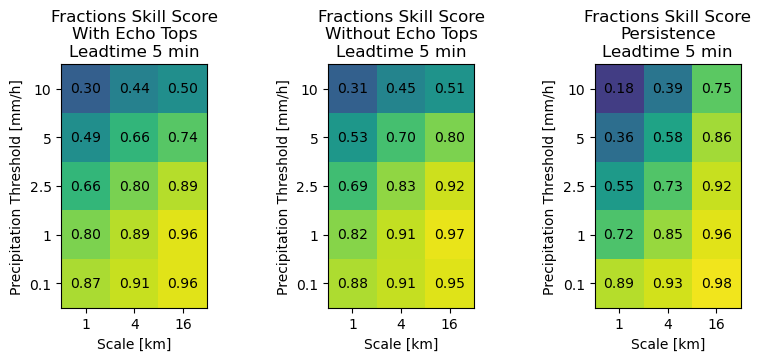

In [26]:
import matplotlib.animation as animate
from IPython.display import HTML

l = 5
fss_thr = (0.1, 1, 2.5, 5, 10)
fss_scale = (1, 4, 16)

fss_weth = np.nanmean(tot_FSS[0:8], axis=(0,1))
fss_neth = np.nanmean(tot_FSS[8:16], axis=(0,1))
fss_pers = np.nanmean(tot_FSS[16:], axis=(0,1))

fig, axes = plt.subplots(1, 3, figsize=(8, 3.5), width_ratios=(1, 1, 1), layout='constrained')

def update(l):
    for ax in axes:
        ax.clear()
    fss_visualize(fss_weth[l], thr=fss_thr, scale=fss_scale, ax=axes[0], subtitle=f'With Echo Tops\nLeadtime {str((l+1)*5)} min')
    fss_visualize(fss_neth[l], thr=fss_thr, scale=fss_scale, ax=axes[1], subtitle=f'Without Echo Tops\nLeadtime {str((l+1)*5)} min')
    fss_visualize(fss_pers[l], thr=fss_thr, scale=fss_scale, ax=axes[2], subtitle=f'Persistence\nLeadtime {str((l+1)*5)} min')

ani = animate.FuncAnimation(fig=fig, func=update, frames=18)
htmlstring = HTML(ani.to_jshtml())

with open(f"FSS.html", "w") as file:
    file.write(htmlstring.data)

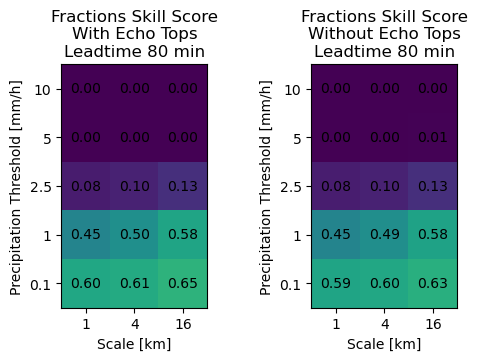

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3.5), width_ratios=(1, 1), layout='constrained')
l = 15
fss_visualize(fss_weth[l], thr=fss_thr, scale=fss_scale, ax=axes[0], subtitle=f'With Echo Tops\nLeadtime {str((l+1)*5)} min')
fss_visualize(fss_neth[l], thr=fss_thr, scale=fss_scale, ax=axes[1], subtitle=f'Without Echo Tops\nLeadtime {str((l+1)*5)} min')

plt.savefig("fss-80.pdf", bbox_inches='tight')

In [159]:
fss_weth = np.nanmean(tot_FSS[0:8], axis=(0))
fss_neth = np.nanmean(tot_FSS[8:16], axis=(0))
fss_diff = fss_neth - fss_weth # negative values mean that the model with echo tops performed better

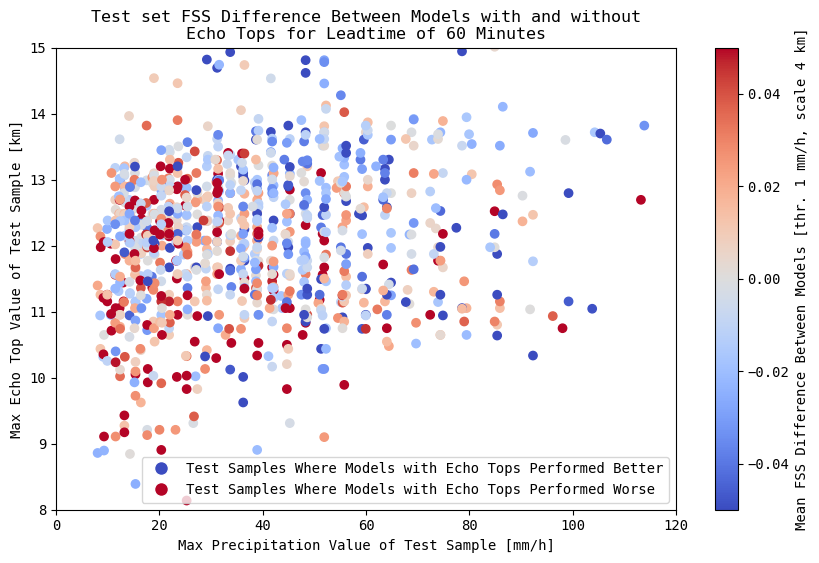

In [318]:
import matplotlib as mpl
from matplotlib.lines import Line2D

l = 11

coolwarm = mpl.colormaps['coolwarm']

fig, ax = plt.subplots(figsize=(10, 6))

fss_thr_idx = 1
fss_scale_idx = 1

plt.scatter(pcp_top_np[:,l+4], eth_top_np[:,l+4], c=fss_diff[:, l, fss_thr_idx, fss_scale_idx], vmin=-0.05, vmax=0.05, cmap='coolwarm', alpha=1)

plt.colorbar(label=f'Mean FSS Difference Between Models [thr. {fss_thr[fss_thr_idx]} mm/h, scale {fss_scale[fss_scale_idx]} km]')

plt.xlim(0, 120)
plt.ylim(8, 15)

plt.xlabel('Max Precipitation Value of Test Sample [mm/h]')
plt.ylabel('Max Echo Top Value of Test Sample [km]')

plt.title(f'Test set FSS Difference Between Models with and without\nEcho Tops for Leadtime of {(l+1)*5} Minutes')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Test Samples Where Models with Echo Tops Performed Better',
                          markerfacecolor=coolwarm(0.0), markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Test Samples Where Models with Echo Tops Performed Worse',
                          markerfacecolor=coolwarm(1.0), markersize=10)]

plt.legend(handles=legend_elements)

plt.savefig(f"fss-8v8-test-set-{fss_thr[fss_thr_idx]}-{fss_scale[fss_scale_idx]}.pdf", bbox_inches='tight')

# zaporne - modre su sample, kde bol vyssi error bez ETH
# kladne - cervene su sample, kde bol vyssi error s ETH

# Show max ETH

In [319]:
def read_h5_echotops(filename):
    with h5py.File(filename, "r") as hf:
        PV = np.array(hf['image1']['image_data'])
        formula = hf['image1']['calibration'].attrs.get('calibration_formulas')
        if isinstance(formula, np.ndarray):
            formula = formula[0].decode('utf-8').split('=')[1].strip()
        else:
            formula = formula.decode('utf-8').split('=')[1].strip()
        PV = np.float16(PV)
        PV[PV == 255] = 0
        return eval(formula)
    
def read_h5_composite(filename):
    """"Read h5 composite."""
    with h5py.File(filename, "r") as hf:
        data = np.array(hf['image1']['image_data'])
        data =  data * 0.5 - 31.5
    return data

In [ ]:
years = len(np.unique([x[0:4] for x in ds.metadata.datetime]))
max_eth = np.zeros((2, 765, 700), dtype=np.float32)

for i, name in enumerate(tqdm(ds.metadata.filename_eth, total=len(ds.metadata.filename_eth))):
    fn = os.path.join('/ETH', name)

    
    #if int(name[16:22]) <= 201609:
        #max_eth[0] = np.maximum(max_eth[0], im)
    if int(name[16:22]) > 201610:
        im = read_h5_echotops(fn)
        max_eth[1] = np.maximum(max_eth[1], im)

  0%|          | 0/24118 [00:00<?, ?it/s]

100%|██████████| 24118/24118 [11:18<00:00, 35.56it/s]    


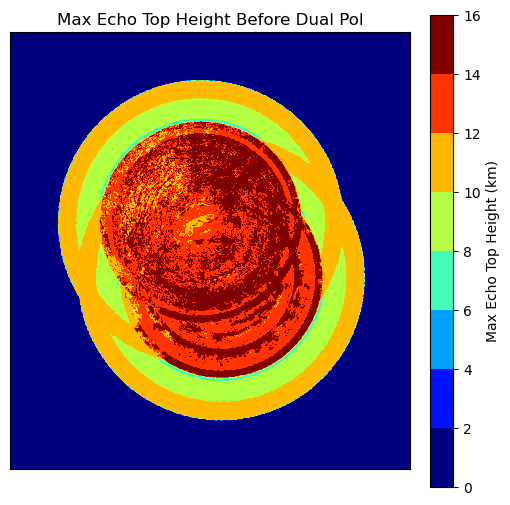

In [139]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML 

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Stepped Turbo', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 16, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
plt.imshow(max_eth[0], cmap=cmap, norm=norm)
plt.colorbar(ticks=bounds, label='Max Echo Top Height (km)')

def update(frame):
    plt.imshow(max_eth[frame], cmap=cmap, norm=norm)
    plt.xticks([])
    plt.yticks([])

    if frame == 0:
        plt.title('Max Echo Top Height Before Dual Pol')
    else:
        plt.title('Max Echo Top Height After Dual Pol')

ani = animate.FuncAnimation(fig=fig, func=update, frames=2)
htmlstring = HTML(ani.to_jshtml())

with open(f"max-eth-recalibrated.html", "w") as file:
    file.write(htmlstring.data)

#plt.show()
#plt.savefig('max_eth-test.pdf', bbox_inches='tight')

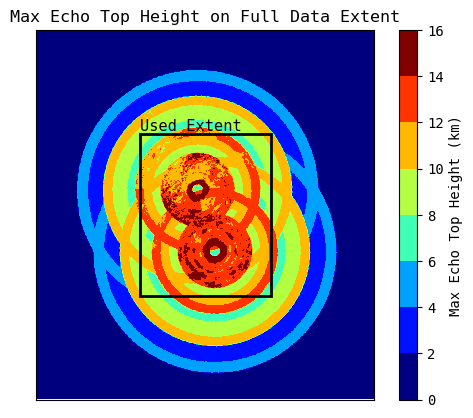

In [328]:
import matplotlib as mpl
import matplotlib.pyplot as plt

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Stepped Turbo', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 16, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(max_eth[1], cmap=cmap, norm=norm)
plt.colorbar(ticks=bounds, label='Max Echo Top Height (km)')
plt.xticks([])
plt.yticks([])

plt.gca().add_patch(
    plt.Rectangle((214, 215), max_eth.shape[-1] - 428, max_eth.shape[-2] - 429, 
                  edgecolor='black', facecolor='none', lw=2)
)

plt.text(214, 215, 'Used Extent', color='black', fontsize=11, ha='left', va='bottom')

plt.title('Max Echo Top Height on Full Data Extent')

#plt.show()
plt.savefig('max_eth.pdf', bbox_inches='tight')